In [1]:
from deepview import DeepView
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import time
import os
# from splinecamC import splinecam
import splinecam
import seaborn as sns
from tqdm.auto import tqdm
from utils_train import train, val_step, train_one, val_step_one
from sklearn.datasets import make_moons, make_circles,make_classification
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<unknown>:3: SyntaxWarning: invalid escape sequence '\i'


# SETUP

In [2]:
seed = 15
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
TRAIN = True
ONE_TRAIN = True
ONE_NODE_OUT = True
import torch.nn.functional as F
act_func = F.sigmoid if ONE_NODE_OUT else lambda y: F.softmax(y, dim=1)
dir = "results/"
if not os.path.isdir(dir): os.mkdir(dir)
train, val_step = (train_one, val_step_one) if ONE_NODE_OUT else (train, val_step)

In [3]:

def make_dataloader(generator,config,
                 noise=0.05,seed=15,
                 batch_size=128):

    


    if config["name"] == "Spiral":
        X,y = generator(n_samples=config["n_samples"], shuffle=False,
                        noise=noise, random_state=seed)#rotations=.5
    else:
       X, y = make_classification(config["n_samples"], n_features= config["n_features"], n_classes=config["n_classes"], random_state=seed,\
                                  n_informative=config["n_informative"], shift=0,n_redundant=0, n_clusters_per_class=2, class_sep = 2, shuffle=False)
        

    inputs = torch.hstack([
        torch.Tensor(X[:,:]),torch.Tensor(y[...,None])
    ])

    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader


def make_spiral(n_samples,
                shuffle=False,
                noise=1,
                random_state=0,
                rotations=1.5,
                ):
  '''
  Make spiral dataset
  '''

  N = n_samples
  pi = rotations*np.pi
  theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  x_a = data_a + np.random.randn(N,2)*1

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  x_b = data_b + np.random.randn(N,2)*1

  res_a = np.append(x_a, np.zeros((N,1)), axis=1)
  res_b = np.append(x_b, np.ones((N,1)), axis=1)

  res = np.append(res_a, res_b, axis=0)
  np.random.shuffle(res)

  return res[:,:2],res[:,-1]

In [4]:
experiment_config = {"Custom": {"name": "Custom",
                                "n_features":2,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":2},
                     "Spiral":{"name": "Spiral",
                               "n_features":2,
                                "n_samples":10000,
                                "n_classes":2,
                                "n_informative":2},
                     "Three":{"name": "Three",
                              "n_features":3,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":3}}
exp_name = "Custom"
select_config = experiment_config[exp_name]
n_features = select_config["n_features"]
n_informative = select_config["n_informative"]
n_classes = select_config["n_classes"]
n_samples = select_config["n_samples"]

In [5]:
#@title Prepare Data and Specify Input Domain

# prepare data
# dataloader = make_dataloader(make_moons,10000)
# dataloader = make_dataloader(make_circles,10000)
dataloader = make_dataloader(make_spiral,select_config)



# dataloader = make_dataloader(0,n_samples)
tot_idx = range(n_samples)
train_idx, test_idx = train_test_split(tot_idx, test_size = 0.15, random_state=seed)
X = dataloader.__dict__['dataset'][:,:-1]
y = dataloader.__dict__['dataset'][:,-1]
# # Train set
y_train = y[train_idx]

# # Test set HOLDOUT SET
y_test =y[test_idx]

Text(0.5, 1.0, 'Data')

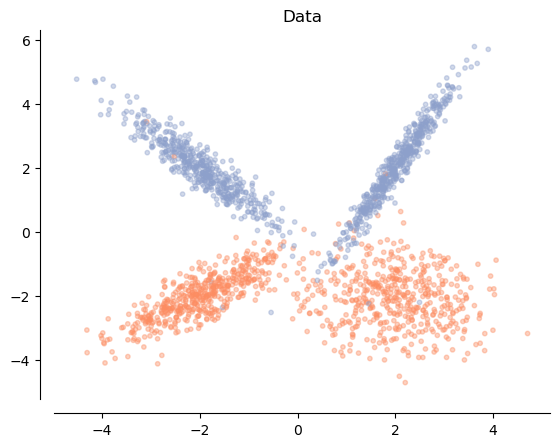

In [6]:
plt.rcParams['figure.dpi'] = 100
custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)
sns.despine(offset=10)
ax.set_title("Data")

## NETWORK

In [7]:
##model def

width = 10
depth = 5
activation_fn = torch.nn.ReLU ## torch.nn.LeakyReLU
device='cpu'
# train = True
bias = True

# create model
def get_model():
  layers = [torch.nn.Flatten()]
  for i in range(depth):
      if i == 0:
          layers.append(torch.nn.Linear(np.prod(n_features), width))
          layers.append(activation_fn())
      elif i == depth - 1:
          layers.append(nn.Linear(int(width), 1 if ONE_NODE_OUT else n_classes))
      # elif i == depth - 2:
      #     layers.append(nn.MaxPool1d(2))
      else:
          layers.append(nn.Linear(width, width))
          layers.append(activation_fn())
  return nn.Sequential(*layers).to(device)
model = get_model()
## bias cant be none for splinecam library, hence we separately set it to zero
if not bias:
  for layer in model:
    if hasattr(layer,'bias'):
      layer.bias = torch.nn.Parameter(torch.zeros_like(layer.bias)+1e-6)

In [8]:
(dataloader.__dict__['dataset'][0]).dtype, model.type

(torch.float32,
 <bound method Module.type of Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=2, out_features=10, bias=True)
   (2): ReLU()
   (3): Linear(in_features=10, out_features=10, bias=True)
   (4): ReLU()
   (5): Linear(in_features=10, out_features=10, bias=True)
   (6): ReLU()
   (7): Linear(in_features=10, out_features=10, bias=True)
   (8): ReLU()
   (9): Linear(in_features=10, out_features=1, bias=True)
 )>)

# TRAIN

In [9]:
#@title Train and visualize per iteration
if ONE_TRAIN:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()

    epochs = 200
    device = 'cpu'
    model = model.to(device)

    for epoch in tqdm(range(1, epochs + 1)):

        ## train step
        val_acc = 0
        model.train()
        total_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):
            model.type(torch.float32)
            # prep data
            
            data,target = data[:,:-1],data[:,-1:]
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad() # zero accumulated gradients
            output = model(data)

            # calculate loss and perform backprop
            loss = criterion(output, target.view(-1,1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            y_pred_class = F.sigmoid(output).round() if ONE_NODE_OUT else torch.argmax(torch.softmax(output,dim=1),dim=1)
            val_acc += ((y_pred_class.view(-1) == target.flatten().view(-1)).sum().item()/len(target))#/2

        # model.cuda()
        model.train()
        model.type(torch.float32)

        # print loss stats
        print("Epoch: {}, Loss: {}, Acc: {}".format(epoch, total_loss / len(dataloader), val_acc/(batch_idx+1)))
        # ## visualize partition

    

  6%|▋         | 13/200 [00:00<00:02, 67.48it/s]

Epoch: 1, Loss: 0.6898173540830612, Acc: 0.4710477941176471
Epoch: 2, Loss: 0.6774834468960762, Acc: 0.5397058823529413
Epoch: 3, Loss: 0.6609786339104176, Acc: 0.7693014705882353
Epoch: 4, Loss: 0.632203608751297, Acc: 0.9056985294117647
Epoch: 5, Loss: 0.5818623751401901, Acc: 0.9213235294117647
Epoch: 6, Loss: 0.5048473607748747, Acc: 0.9144301470588235
Epoch: 7, Loss: 0.4130750671029091, Acc: 0.9121323529411764
Epoch: 8, Loss: 0.33061228692531586, Acc: 0.9113051470588235
Epoch: 9, Loss: 0.2647440526634455, Acc: 0.9144301470588235
Epoch: 10, Loss: 0.20690168999135494, Acc: 0.919485294117647
Epoch: 11, Loss: 0.15911265322938561, Acc: 0.9215992647058824
Epoch: 12, Loss: 0.12428066041320562, Acc: 0.9231617647058823
Epoch: 13, Loss: 0.10060047451406717, Acc: 0.9240808823529412
Epoch: 14, Loss: 0.08642557798884809, Acc: 0.9241727941176471
Epoch: 15, Loss: 0.07894311344716698, Acc: 0.9237132352941176
Epoch: 16, Loss: 0.07720435806550086, Acc: 0.9221507352941176
Epoch: 17, Loss: 0.07334157

 16%|█▋        | 33/200 [00:00<00:01, 85.06it/s]

Epoch: 20, Loss: 0.06698393129045144, Acc: 0.9232536764705882
Epoch: 21, Loss: 0.06647139019332826, Acc: 0.9229779411764706
Epoch: 22, Loss: 0.06740590836852789, Acc: 0.9228860294117647
Epoch: 23, Loss: 0.06577639793977141, Acc: 0.9234375
Epoch: 24, Loss: 0.06504038826096803, Acc: 0.9233455882352941
Epoch: 25, Loss: 0.06365318119060248, Acc: 0.9246323529411765
Epoch: 26, Loss: 0.06524861394427717, Acc: 0.9240808823529412
Epoch: 27, Loss: 0.0669163876445964, Acc: 0.9240808823529412
Epoch: 28, Loss: 0.06385398551356047, Acc: 0.9252757352941177
Epoch: 29, Loss: 0.06535527430241928, Acc: 0.9244485294117647
Epoch: 30, Loss: 0.06231924775056541, Acc: 0.924264705882353
Epoch: 31, Loss: 0.06151695048902184, Acc: 0.9248161764705882
Epoch: 32, Loss: 0.061699514859355986, Acc: 0.9252757352941177
Epoch: 33, Loss: 0.060879157041199505, Acc: 0.9255514705882353
Epoch: 34, Loss: 0.061735551338642836, Acc: 0.9257352941176471
Epoch: 35, Loss: 0.06091532262507826, Acc: 0.9248161764705882
Epoch: 36, Loss:

 26%|██▋       | 53/200 [00:00<00:01, 89.91it/s]

Epoch: 39, Loss: 0.06163844047114253, Acc: 0.9254595588235294
Epoch: 40, Loss: 0.059426850522868335, Acc: 0.9257352941176471
Epoch: 41, Loss: 0.05934258765773848, Acc: 0.9257352941176471
Epoch: 42, Loss: 0.060187998693436384, Acc: 0.9251838235294118
Epoch: 43, Loss: 0.06126639945432544, Acc: 0.9254595588235294
Epoch: 44, Loss: 0.061374209355562925, Acc: 0.9249999999999999
Epoch: 45, Loss: 0.05926451680716127, Acc: 0.9252757352941177
Epoch: 46, Loss: 0.05998596257995814, Acc: 0.9261948529411765
Epoch: 47, Loss: 0.05878772778669372, Acc: 0.9273897058823529
Epoch: 48, Loss: 0.060383045580238104, Acc: 0.9252757352941177
Epoch: 49, Loss: 0.05904993851436302, Acc: 0.9271139705882353
Epoch: 50, Loss: 0.05999541748315096, Acc: 0.9251838235294118
Epoch: 51, Loss: 0.05967721773777157, Acc: 0.9257352941176471
Epoch: 52, Loss: 0.05853949848096818, Acc: 0.9254595588235294
Epoch: 53, Loss: 0.057909968541935086, Acc: 0.9278492647058824
Epoch: 54, Loss: 0.05837734369561076, Acc: 0.9275735294117647
Epo

 36%|███▋      | 73/200 [00:00<00:01, 91.69it/s]

Epoch: 58, Loss: 0.05721114540938288, Acc: 0.9264705882352942
Epoch: 59, Loss: 0.05849656951613724, Acc: 0.9277573529411764
Epoch: 60, Loss: 0.057775917870458215, Acc: 0.9273897058823529
Epoch: 61, Loss: 0.05737242451868951, Acc: 0.9278492647058824
Epoch: 62, Loss: 0.0574754310073331, Acc: 0.9278492647058824
Epoch: 63, Loss: 0.05828945786925033, Acc: 0.927297794117647
Epoch: 64, Loss: 0.06130666600074619, Acc: 0.9272058823529411
Epoch: 65, Loss: 0.0579700386733748, Acc: 0.9280330882352942
Epoch: 66, Loss: 0.05854855268262327, Acc: 0.927297794117647
Epoch: 67, Loss: 0.05699450091924518, Acc: 0.9283088235294118
Epoch: 68, Loss: 0.05699332267977297, Acc: 0.9283088235294118
Epoch: 69, Loss: 0.05756642873166129, Acc: 0.9271139705882353
Epoch: 70, Loss: 0.057724147744011134, Acc: 0.9280330882352942
Epoch: 71, Loss: 0.05815457127755508, Acc: 0.9280330882352942
Epoch: 72, Loss: 0.056751694297418, Acc: 0.9278492647058824
Epoch: 73, Loss: 0.056776510551571846, Acc: 0.9283088235294118
Epoch: 74, 

 46%|████▋     | 93/200 [00:01<00:01, 92.38it/s]

Epoch: 77, Loss: 0.05877739901188761, Acc: 0.9280330882352942
Epoch: 78, Loss: 0.0578725776867941, Acc: 0.9280330882352942
Epoch: 79, Loss: 0.057465270278044045, Acc: 0.9280330882352942
Epoch: 80, Loss: 0.056751431606244296, Acc: 0.9283088235294118
Epoch: 81, Loss: 0.05810301867313683, Acc: 0.9275735294117647
Epoch: 82, Loss: 0.05856160947587341, Acc: 0.9277573529411764
Epoch: 83, Loss: 0.05818321241531521, Acc: 0.9280330882352942
Epoch: 84, Loss: 0.05749314517015591, Acc: 0.9284926470588236
Epoch: 85, Loss: 0.05679260892793536, Acc: 0.9280330882352942
Epoch: 86, Loss: 0.057191709987819195, Acc: 0.9280330882352942
Epoch: 87, Loss: 0.05617061798693612, Acc: 0.9283088235294118
Epoch: 88, Loss: 0.05647463264176622, Acc: 0.9280330882352942
Epoch: 89, Loss: 0.056398501445073634, Acc: 0.9280330882352942
Epoch: 90, Loss: 0.06044050125638023, Acc: 0.9272058823529411
Epoch: 91, Loss: 0.057218601112253964, Acc: 0.9280330882352942
Epoch: 92, Loss: 0.056466954469215125, Acc: 0.9280330882352942
Epo

 56%|█████▋    | 113/200 [00:01<00:00, 92.65it/s]

Epoch: 96, Loss: 0.05690746469190344, Acc: 0.9280330882352942
Epoch: 97, Loss: 0.05629182723350823, Acc: 0.9284926470588236
Epoch: 98, Loss: 0.05703280039597303, Acc: 0.9284926470588236
Epoch: 99, Loss: 0.057699162629432976, Acc: 0.9280330882352942
Epoch: 100, Loss: 0.055996559211052954, Acc: 0.9283088235294118
Epoch: 101, Loss: 0.05632037407485768, Acc: 0.9280330882352942
Epoch: 102, Loss: 0.055494112661108375, Acc: 0.9283088235294118
Epoch: 103, Loss: 0.05622901790775359, Acc: 0.9283088235294118
Epoch: 104, Loss: 0.05645805655512959, Acc: 0.9284926470588236
Epoch: 105, Loss: 0.05567902378970757, Acc: 0.9280330882352942
Epoch: 106, Loss: 0.05580822448246181, Acc: 0.9287683823529411
Epoch: 107, Loss: 0.0558086569653824, Acc: 0.9287683823529411
Epoch: 108, Loss: 0.057920755818486214, Acc: 0.9282169117647059
Epoch: 109, Loss: 0.055399848584784195, Acc: 0.9283088235294118
Epoch: 110, Loss: 0.05533224425744265, Acc: 0.9283088235294118
Epoch: 111, Loss: 0.05808153247926384, Acc: 0.927941176

 66%|██████▋   | 133/200 [00:01<00:00, 92.68it/s]

Epoch: 115, Loss: 0.05739141697995365, Acc: 0.9277573529411764
Epoch: 116, Loss: 0.05604610464069992, Acc: 0.9282169117647059
Epoch: 117, Loss: 0.05524127185344696, Acc: 0.9287683823529411
Epoch: 118, Loss: 0.057611629366874695, Acc: 0.9279411764705883
Epoch: 119, Loss: 0.0562166919989977, Acc: 0.9284926470588236
Epoch: 120, Loss: 0.055545744486153126, Acc: 0.9284926470588236
Epoch: 121, Loss: 0.055167477345094085, Acc: 0.9283088235294118
Epoch: 122, Loss: 0.05689463403541595, Acc: 0.9280330882352942
Epoch: 123, Loss: 0.05476143053965643, Acc: 0.9287683823529411
Epoch: 124, Loss: 0.059677888348232955, Acc: 0.9274816176470588
Epoch: 125, Loss: 0.05493611001293175, Acc: 0.9287683823529411
Epoch: 126, Loss: 0.056044941185973585, Acc: 0.9279411764705883
Epoch: 127, Loss: 0.0567431605886668, Acc: 0.9282169117647059
Epoch: 128, Loss: 0.057412873953580856, Acc: 0.9282169117647059
Epoch: 129, Loss: 0.054763157095294446, Acc: 0.9287683823529411
Epoch: 130, Loss: 0.05496549012605101, Acc: 0.9280

 72%|███████▏  | 143/200 [00:01<00:00, 89.57it/s]

Epoch: 134, Loss: 0.05455545970471576, Acc: 0.9283088235294118
Epoch: 135, Loss: 0.05492066952865571, Acc: 0.9287683823529411
Epoch: 136, Loss: 0.05636746989330277, Acc: 0.9280330882352942
Epoch: 137, Loss: 0.05493989941896871, Acc: 0.9283088235294118
Epoch: 138, Loss: 0.05498643539613113, Acc: 0.9284926470588236
Epoch: 139, Loss: 0.054695173748768866, Acc: 0.9287683823529411
Epoch: 140, Loss: 0.055526686017401516, Acc: 0.9284926470588236
Epoch: 141, Loss: 0.054882624302990735, Acc: 0.9283088235294118
Epoch: 142, Loss: 0.055064341286197305, Acc: 0.9284926470588236
Epoch: 143, Loss: 0.057340860657859594, Acc: 0.9279411764705883
Epoch: 144, Loss: 0.05482983042020351, Acc: 0.9284926470588236
Epoch: 145, Loss: 0.054290049243718386, Acc: 0.9283088235294118
Epoch: 146, Loss: 0.05697885324480012, Acc: 0.9274816176470588
Epoch: 147, Loss: 0.05428638949524611, Acc: 0.9283088235294118
Epoch: 148, Loss: 0.055482967058196664, Acc: 0.9284926470588236
Epoch: 149, Loss: 0.05668497161241248, Acc: 0.92

 82%|████████▏ | 163/200 [00:01<00:00, 91.34it/s]

Epoch: 152, Loss: 0.05808941804571077, Acc: 0.9279411764705883
Epoch: 153, Loss: 0.05507681577000767, Acc: 0.9280330882352942
Epoch: 154, Loss: 0.05469054140849039, Acc: 0.9282169117647059
Epoch: 155, Loss: 0.054899661045055836, Acc: 0.9284926470588236
Epoch: 156, Loss: 0.05409597675316036, Acc: 0.9284926470588236
Epoch: 157, Loss: 0.05525386714725755, Acc: 0.9280330882352942
Epoch: 158, Loss: 0.055586229369509965, Acc: 0.9277573529411764
Epoch: 159, Loss: 0.054411694582086056, Acc: 0.9280330882352942
Epoch: 160, Loss: 0.054878249182365835, Acc: 0.9284926470588236
Epoch: 161, Loss: 0.05383212125161663, Acc: 0.9283088235294118
Epoch: 162, Loss: 0.055180904106236994, Acc: 0.9280330882352942
Epoch: 163, Loss: 0.05356796248815954, Acc: 0.9287683823529411
Epoch: 164, Loss: 0.05407834850484505, Acc: 0.9287683823529411
Epoch: 165, Loss: 0.05614147672895342, Acc: 0.9277573529411764
Epoch: 166, Loss: 0.0540870595141314, Acc: 0.9287683823529411
Epoch: 167, Loss: 0.055361658916808665, Acc: 0.9277

 92%|█████████▏| 183/200 [00:02<00:00, 92.47it/s]

Epoch: 171, Loss: 0.056014263769611716, Acc: 0.9282169117647059
Epoch: 172, Loss: 0.05515177588677034, Acc: 0.9284926470588236
Epoch: 173, Loss: 0.05369214486563578, Acc: 0.9287683823529411
Epoch: 174, Loss: 0.05595093342708424, Acc: 0.9277573529411764
Epoch: 175, Loss: 0.053917074867058545, Acc: 0.9287683823529411
Epoch: 176, Loss: 0.05386016005650163, Acc: 0.9287683823529411
Epoch: 177, Loss: 0.05427593528293073, Acc: 0.9282169117647059
Epoch: 178, Loss: 0.05467947683064267, Acc: 0.9280330882352942
Epoch: 179, Loss: 0.05493467132328078, Acc: 0.9280330882352942
Epoch: 180, Loss: 0.053618578938767314, Acc: 0.9287683823529411
Epoch: 181, Loss: 0.05654131309711374, Acc: 0.9279411764705883
Epoch: 182, Loss: 0.05461783637292683, Acc: 0.9280330882352942
Epoch: 183, Loss: 0.05544242722680792, Acc: 0.9279411764705883
Epoch: 184, Loss: 0.056711610697675496, Acc: 0.9274816176470588
Epoch: 185, Loss: 0.053555461985524744, Acc: 0.9283088235294118
Epoch: 186, Loss: 0.05361463420558721, Acc: 0.9287

100%|██████████| 200/200 [00:02<00:00, 89.66it/s]

Epoch: 190, Loss: 0.0566468226024881, Acc: 0.9272058823529411
Epoch: 191, Loss: 0.053913357318378985, Acc: 0.9284926470588236
Epoch: 192, Loss: 0.053504668816458434, Acc: 0.9283088235294118
Epoch: 193, Loss: 0.054287519422359765, Acc: 0.9282169117647059
Epoch: 194, Loss: 0.053162744152359664, Acc: 0.9287683823529411
Epoch: 195, Loss: 0.05530079864547588, Acc: 0.9277573529411764
Epoch: 196, Loss: 0.054327696561813354, Acc: 0.9280330882352942
Epoch: 197, Loss: 0.05327988805947825, Acc: 0.9283088235294118
Epoch: 198, Loss: 0.05365348368650302, Acc: 0.9275735294117647
Epoch: 199, Loss: 0.05678698734845966, Acc: 0.9276654411764705
Epoch: 200, Loss: 0.053233330545481294, Acc: 0.9287683823529411


## CROSS VALIDATION

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#generatin the 10 fold data
from sklearn.model_selection import KFold
folds = 10
if TRAIN and not ONE_TRAIN:
  NUM_EPOCHS = 15
  device = "cuda"
  kf = KFold(n_splits=folds)#,random_state=42, shuffle=True

  # Continue the training and validation of the model for all the other folds
  for i, (train_index, test_index) in tqdm(enumerate(kf.split(train_idx))):
    model = get_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn =nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()
    # Keeping the split
    train_str = "train_"+str(i)
    val_str = "val_"+str(i)
    # Turn train and validation Datasets into DataLoaders
    # ds_train = TensorDataset(torch.tensor(X[train_idx][train_index],device=device), torch.tensor(y_train[train_index],device=device).view(-1,1))#, transform=transforms.ToTensor()
    # ds_test = TensorDataset(torch.tensor(X[train_idx][test_index], device=device), torch.tensor(y_train[test_index],device=device).view(-1,1))
    ds_train = TensorDataset(X[train_idx][train_index].to(device), y_train[train_index].view(-1,1).to(device))#, transform=transforms.ToTensor()
    ds_test = TensorDataset(X[train_idx][test_index].to(device), y_train[test_index].view(-1,1).to(device))
    trainloader = DataLoader(ds_train,batch_size=16,shuffle=True)
    validationloader = DataLoader(ds_test,batch_size=16)
    # Start the timer
    
    from timeit import default_timer as timer
    start_time = timer()
    # Train model
    model_results = train(model=model,
                          train_dataloader=trainloader,
                          val_dataloader=validationloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=NUM_EPOCHS,
                          split=i,
                          dir=dir)
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
    results_df_name = f"{dir}/{path}"+str(i)+".csv"
    results_df.to_csv(results_df_name)

## TRAIN PERFORMANCES

In [11]:
if not ONE_TRAIN:
  # sns.set_theme()
  results = []
  val_accuracies = np.zeros([10,1])
  path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
  for i in range(folds):
    results.append(pd.read_csv(f"{dir}/{path}{i}.csv"))
    val_accuracies[i] = np.max(results[i]["val_acc"])

  # Get the fold corresponding to the overall best
  index = np.argmax(val_accuracies)


  res = pd.concat(results)
  # res.replace([np.inf, -np.inf], np.nan)
  res = res.map(lambda x: np.nan if x in [np.inf, -np.inf] else x)
  len(results), index, val_accuracies

In [12]:
if not ONE_TRAIN:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(data=res, x="epochs", y="train_loss", err_style="band", label="train", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="val_loss", err_style="band", label="val", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="train_acc", err_style="band", label="train", ax=axs[1])
    sns.lineplot(data=res, x="epochs", y="val_acc", err_style="band", label="val", ax=axs[1])
    sns.despine(offset=10)
    plt.tight_layout()


In [13]:
if not ONE_TRAIN:
    # Looking across all the best validation accuracies obtained from the ten folds
    val_accuracies = np.zeros([10,1])
    path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
    for i in range(folds):
        results_string = f"{dir}/{path}"+str(i)+".csv"
        val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])

    # Get the fold corresponding to the overall best
    index = np.argmax(val_accuracies)
    index

In [14]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=torch.device("cuda"))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [15]:
x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)
ds_holdout=TensorDataset(x_holdout_tensor,y_binary_test_tensor)
holdout_loader = DataLoader(ds_holdout,batch_size=16)


/tmp/ipykernel_1217863/2996718076.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
/tmp/ipykernel_1217863/2996718076.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)


In [16]:
if not ONE_TRAIN:
    val_accuracies = np.zeros([10,1])
    ck_path = "One_checkpoint_" if ONE_NODE_OUT else "checkpoint_"
    loss_fn = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()
    for i in range(folds):
        model_string = f"{dir}/{ck_path}"+str(i)+".pth"
        model_cp = load_checkpoint(model_string)
        
        val_loss, val_accuracies[i], f1,_= val_step(model=model_cp.to(device),
                    dataloader=holdout_loader,
                    loss_fn=loss_fn)
        # val_accuracies[i] = val_acc
        print("ACCURACY: ", val_accuracies[i], "F1: ",f1)
    index = np.argmax(val_accuracies)
    index

## Loading best model

In [17]:
if not ONE_TRAIN:
    model_string = f"{dir}/{ck_path}"+str(index)+".pth"
    # model_string = "../results/good_models/checkpoint_4_clsmall.pth"
    model_cp = load_checkpoint(model_string)
    model_cp.eval()
    model_cp.to(device)
    loss_fn = nn.CrossEntropyLoss().to(device) 
    print(model_cp)

    val_loss, val_acc, f1,_ = val_step(model=model_cp,
                dataloader=holdout_loader,
                loss_fn=loss_fn)
    print("\nACCURACY: ", val_acc, "\nF1: ",f1)
    model = model_cp
    # conf_matrix = conf_matrix.cpu().numpy()
    # conf_matrix, val_loss

In [18]:
class_0_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==0)]
class_1_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==1)]
# class_2_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==2)]

## GPU IBS

In [19]:
pred_bound = 1/2
get_class = lambda x: torch.round(x, decimals=0) if ONE_NODE_OUT else lambda x: torch.argmax(x, dim=1)
def IBS_gpu(bss, model, target_class_0,target_class_1, data, precision = 0.05, device = 'cuda', noise_mul = 2, max_iters = None):
    bss.to(device)
    model.to(device)
    model.eval()
    iters_count = torch.zeros((bss.shape[0],2),dtype=torch.int64, device=device)
    baselines = []
    iteration = 0
    while(bss.shape[0]>0 and (iteration < max_iters if not max_iters is None else True)):
        # print(iteration, " bss dim:", bss.shape[0])
        outs = model(bss)
        softmax_preds = act_func(outs)
        preds = softmax_preds[:,0]
        cond = ((pred_bound-precision) < preds)  * (preds <(pred_bound+precision))
        baselines.extend([*[x.cpu() for x in bss[torch.where(cond)]]])
        bss = bss[torch.where(~cond)]
        iters_count = iters_count[torch.where(~cond)]
        #compute step
        idxs = get_class(softmax_preds[torch.where(~ cond)]).type(torch.bool)#torch.argmax(softmax_preds[torch.where(~ cond)], dim=1)
        # idxs = softmax_preds[torch.where(~ cond)].round().type(torch.int32)
        new_idx = torch.zeros(bss.shape[0], dtype=torch.int32,device=device)
        
        for i, (idx, c) in enumerate(zip(idxs, iters_count)):
            try:
                new_idx[i] = target_class_0[c[0]%len(target_class_0)] if idx else target_class_1[c[1]%len(target_class_1)]
            except:
                print("Out of data")

        iters_count[torch.arange(idxs.size(0)), (~ idxs).long()] +=1 #MOD
        pred_values =  softmax_preds[torch.where(~ cond)[0]].squeeze()# MOD
        dirs = torch.tensor(data[new_idx.cpu()], device=device, dtype=torch.float32).view(bss.shape)
        dirs =dirs- bss 
        multi = noise_mul# ((max_iters/2-iteration) / max_iters/2)*noise_mul
        intensity = torch.round(((pred_values-(1-pred_values))/2) * multi, decimals=5)
        intensity = abs(intensity)
        weighted_input = dirs*intensity.view(-1, 1)
        bss = bss + weighted_input
        iteration += 1
    
    print(bss.shape[0], iteration )
    del weighted_input, dirs, bss
    return torch.stack(baselines) if len(baselines)>0 else []




In [20]:
def inference_transf(x):
    return torch.tensor(x, dtype=torch.float32, device=device).view(1,n_features)

In [22]:
classified=[[],[]]
device = 'cuda'
model.to(device)
for i,x in enumerate( X):
    pred = act_func(model(inference_transf(x)))
    pred_idx = pred.round() if ONE_NODE_OUT else torch.argmax(pred, dim=1)
    classified[int(pred_idx)].append(i)

/tmp/ipykernel_1217863/1622146021.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32, device=device).view(1,n_features)


# Informed Baseline Search

To run `IBS_gpu` we need to setup a dataloader with data that we use for search baselines, the batchsize is crucial. Then we need *class pools*, here we use `classified` lists to identify the sample idx by class (we use idxs to save memory)

In [23]:
temp = []

data_ds = TensorDataset(torch.tensor(X, requires_grad=False))
data_l = DataLoader(data_ds, batch_size=1024)
for d in tqdm(data_l):
    temp.extend(IBS_gpu(torch.tensor(d[0].clone(),device="cuda", dtype=torch.float32).view(-1,n_features), model, classified[0],classified[1], data=X, precision = 0.01, device = 'cuda', noise_mul = 1/20, max_iters = 100))
    torch.cuda.empty_cache()
bss = torch.stack(temp)

/tmp/ipykernel_1217863/898376760.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_ds = TensorDataset(torch.tensor(X, requires_grad=False))
  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_1217863/898376760.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp.extend(IBS_gpu(torch.tensor(d[0].clone(),device="cuda", dtype=torch.float32).view(-1,n_features), model, classified[0],classified[1], data=X, precision = 0.01, device = 'cuda', noise_mul = 1/20, max_iters = 100))
/tmp/ipykernel_1217863/3811722611.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

1 100


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

0 99


In [24]:
bs_arr = bss.detach().cpu().numpy()

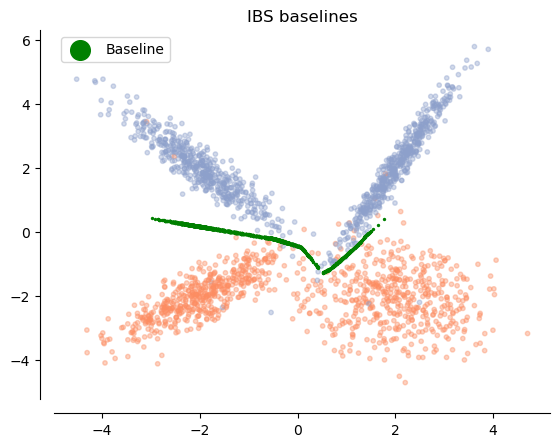

In [25]:
plt.rcParams['figure.dpi'] = 100
custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)



ax.scatter(*bs_arr.T, zorder=10000000000, c='g', s=2, label="Baseline")

sns.despine(offset=10)
ax.set_title("IBS baselines")
ax.legend(*ax.get_legend_handles_labels(),markerscale=10)

# SPLINECAM

In [26]:

if n_features == 2:
    xlow,ylow= dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
    xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

    # # # ROI square domain at the input space
    # pad = 1.5
    domain = torch.tensor([
        [xlow,ylow],
        [xlow,yhigh],
        [xhigh,yhigh],
        [xhigh,ylow,],
        [xlow,ylow],
        
    ])

    T  = torch.eye(3)[:-1]
    # from adjustText import adjust_text
    model.cpu()
    model.eval()
    model.type(torch.float64)

    print('Wrapping model with SplineCam...')

    NN = splinecam.wrappers.model_wrapper(
        model,
        input_shape=(1,n_features),
        T = T,
        dtype = torch.float64,
        device = 'cpu',
        # is_classifier=True
    )

    ## check .forward() and matmul operation equivalence
    # print('Verifying wrapped model...')
    flag =  NN.verify()
    # print('Model.forward and matmul equivalence check', flag)
    assert flag

    ## specify level set for output neuron, for db visualization
    thresh = 0.
    NN.layers[-1].Ab[:,-1] = NN.layers[-1].Ab[:,-1] + thresh

    print(domain.shape)
    ## get partitions
    out_cyc,endpoints,Abw = splinecam.compute.get_partitions_with_db(domain,T,NN)


Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Wrapping layer 9...
torch.Size([5, 2])
Finding regions from first layer graph


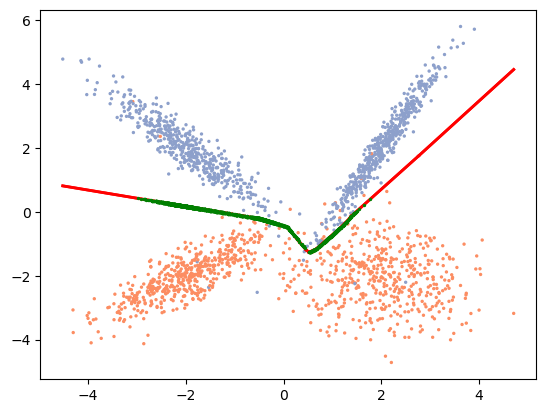

In [27]:

if n_features == 2:
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2)

    texts = []
    g_pred=[]
    k_pred=[]
    model.eval()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2, alpha=1)
            


    ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
                c = dataloader.__dict__['dataset'][:,-1].numpy(), s=2,
                cmap = custom_cmap)
    ax.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=2, alpha=1)
    # plt.savefig(f'./animation/{epoch}.png',bbox_inches='tight',pad_inches=0)
    plt.show()
    # plt.close()

# deepview

In [28]:
# softmax operation to use in pred_wrapper
softmax = act_func #torch.nn.Softmax(dim=-1)
to_deep_len = 1000 
model.type(torch.float32)
device = "cpu"
model.to(device)
# this is the prediction wrapper, it encapsulates the call to the model
# and does all the casting to the appropriate datatypes
def pred_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        logits = model(tensor)
        probabilities = act_func(logits).cpu().numpy()
    return probabilities


# the classes in the dataset to be used as labels in the plots
classes = (0,1)
X = np.concatenate((class_0_data[:to_deep_len], class_1_data[:to_deep_len],np.array(bs_arr).reshape(-1,n_features)[:to_deep_len*2]), axis=0).reshape(-1,1,n_features)
Y = np.zeros(X.shape[0])
Y[to_deep_len:] = 1

# --- Deep View Parameters ----
batch_size = 512
max_samples = X.shape[0]
data_shape = (1,n_features)
lam = .65 # default parameter
title = f'{n_features} Features'

deepview = DeepView.DeepView(pred_wrapper, classes, max_samples, batch_size, 
                    data_shape, lam=lam, title=title, cmap="Set2")
model.type(torch.float32)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
t0 = time.time()
deepview.add_samples(X, Y.reshape(-1))
print('Time to calculate visualization for %d samples: %.2f sec' % (X.shape[0], time.time() - t0))

Distance calculation 19.98 %
Distance calculation 39.97 %
Distance calculation 59.95 %
Distance calculation 79.94 %
Distance calculation 99.92 %
Embedding samples ...


/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Computing decision regions ...
Time to calculate visualization for 3998 samples: 83.44 sec


In [30]:
def update(handle, orig):
    handle.update_from(orig)
    handle.set_alpha(1)

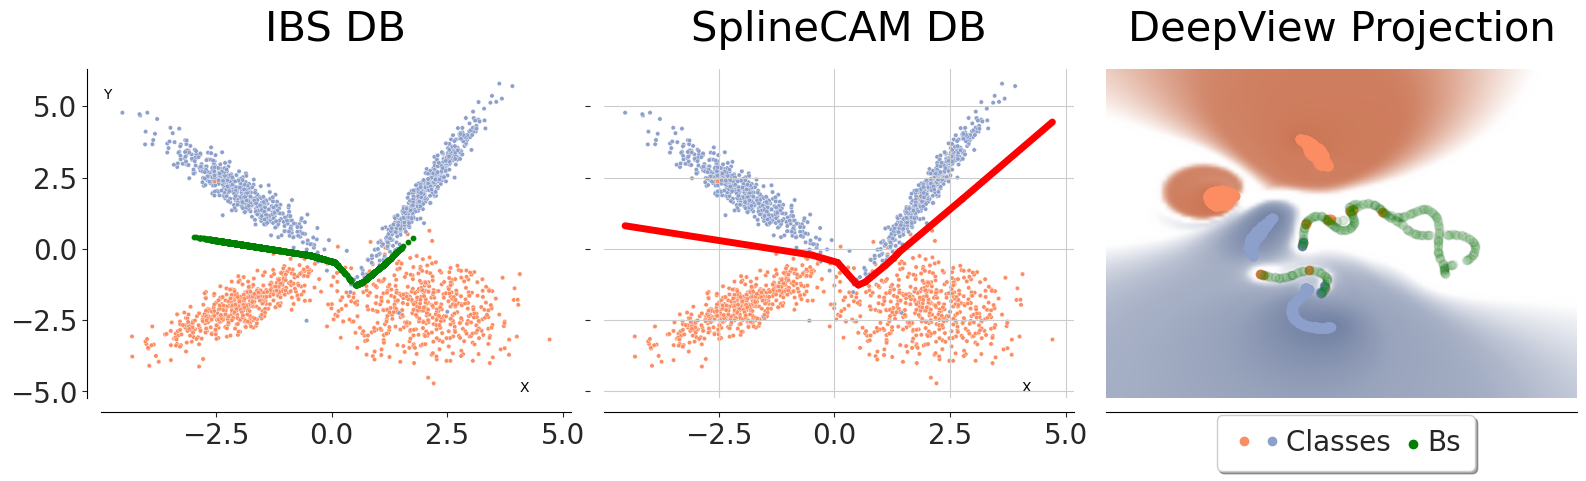

In [31]:
if n_features == 2:
  cols=["X","Y","label"]
  fig, ((ax0,ax1,ax2)) = plt.subplots(1,3, figsize=(16,5));
  sns.set_style("white")

  rc = {
        "figure.dpi": 500,
        # 'figure.figsize':(16,5),
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
      #   'font.family':'Times New Roman',
        'font.size' : 20,
      "axes.titlesize": 30,   # fontsize of the axes title
      "axes.labelsize": "medium",  # fontsize of the x any y labels
      'font.size' : 20,
      'axes.titlepad':20}
  plt.rcParams.update(rc)
  custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

  deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs = .01)
  df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)
  if n_features == 2:
    sns.scatterplot(df, x="X",y="Y", hue="label", s=10, ax=ax0, palette=sns.color_palette("Set2")[1:3])
    sns.scatterplot(df, x="X",y="Y", hue="label" ,s=10, ax=ax1, palette=sns.color_palette("Set2")[1:3])

  ax0.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=10, alpha=1)

  ax1.set_xlim(ax0.get_xlim())
  ax1.set_ylim(ax0.get_ylim())
  ax1.set_yticklabels([])
  ax1.set_ylabel("")

  for each in endpoints:
      if each is not None:
          ax1.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=5, alpha=1)
  
  ax0.legend([],frameon=False)
  ax1.legend([],frameon=False)
  ax0.set_title("IBS DB")
  ax1.set_title("SplineCAM DB")
  ax2.set_title("DeepView Projection")
  sns.despine(offset=10, trim=False)
  sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False, offset=10, trim=False)
  sns.despine(ax=ax2, top=True, right=False, left=True, bottom=False, offset=10, trim=False)
  
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_xlabel("")
  ax2.set_ylabel("")

  h, l = ax2.get_legend_handles_labels()
  
  fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
    plt.Line2D : HandlerLine2D(update_func = update)},\
      labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.837, -0.01],
      fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)
  ax2.legend([],frameon=False)
  # ax1.set_ylabel("Z", rotation='horizontal', y=0.90, labelpad=-50)
  ax0.set_ylabel("Y", rotation='horizontal', y=0.90, labelpad=-70)
  ax0.set_xlabel("X", rotation='horizontal', x =0.90, labelpad=-50)
  ax1.set_xlabel("X", rotation='horizontal', x=0.90, labelpad=-50)
  ax.grid(True);ax1.grid(True)
  plt.tight_layout()
  


In [32]:
import umap
if n_features == 3:
    in_data = np.concatenate([class_0_data,class_1_data])
    labels = np.zeros(in_data.shape[0]+bs_arr.shape[0])
    labels[len(class_0_data):] = 1
    labels[len(class_0_data)+len(class_1_data):] = 2

    reducer = umap.UMAP(50,random_state=seed, init="pca")
    reducer.fit(np.concatenate([in_data,bs_arr]))

    embedding = reducer.transform(np.concatenate([in_data, bs_arr]))

In [33]:

if n_features == 3:
    fig, ((ax0,ax2)) = plt.subplots(1,2, figsize=(20,10)); cols=["X","Y", "Z","label"]
    sns.set_style("white")

    rc = {
        "figure.dpi": 500,
        'figure.figsize':(16,8),
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
        "axes.titlesize": 30,   # fontsize of the axes title
        "axes.labelsize": "medium",  # fontsize of the x any y labels
        'font.size' : 20,
        'axes.titlepad':20}
    plt.rcParams.update(rc)
    custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

    deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs=0.05)
    df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)

    ax0.scatter(embedding[:len(in_data), 0], embedding[:len(in_data), 1], c=labels[:len(in_data)], \
                cmap= mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)]), s=5)
    ax0.scatter(embedding[len(in_data):, 0], embedding[len(in_data):, 1], c=labels[len(in_data):], \
                cmap= mcolors.ListedColormap(["green"]), s=5, alpha=.5)


    ax0.legend([],frameon=False)

    t0 = ax0.set_title("UMAP projection")

    ax2.set_title("DeepView Projection")
    sns.despine(offset=10, trim=False)

    sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False, offset=10, trim=False)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    h,l = ax2.get_legend_handles_labels()
    ax2.legend([],frameon=False)
    fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
                                                    plt.Line2D : HandlerLine2D(update_func = update)},\
                labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.41, +0.02],
                fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)

    plt.tight_layout()
